# CatGAN

## Install and Import Dependencies

In [25]:
import os
# import cv2
import random
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image,ImageOps
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

logger = TensorBoardLogger("tb_logs", name="my_model")
%load_ext tensorboard

download = False
if download:
    !git clone https://github.com/DennisRotondi/visiope_project
    !cd visiope_project
    !pip3 install -r requirements.txt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Dataset Handling

In [29]:
class CatDataset(Dataset):
    
    def __init__(self, 
                 folder, 
                 transform = None
        ):
        
        super().__init__()
        self.folder = Path(folder)
        assert(self.folder.is_dir())
        self.files = list(sorted(self.folder.rglob('*.jpg')))
        assert(self.files)
        self.files_num = len(self.files)
        self.transform = transform


    def __len__(self):
        return self.files_num

    def pil_loader(self,file):
        with file.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        file = self.files[index % self.files_num]
        image = self.pil_loader(file)

        if self.transform is not None:
            image = self.transform(image)
        
        return {
            'file': image,
            'path': str(file)
        }
        
def plot_cats(images, 
                images_per_row, 
                border: float = 3., 
                pad_value: float = 1,
                title = 'Cats images'):
    plt.figure(figsize = (16, 16))
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

visualize some cats from the dataset

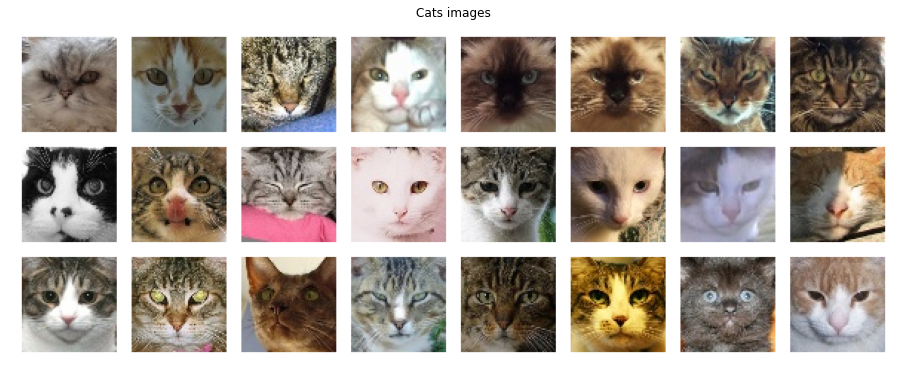

In [34]:
path = "./cats"

catsData = DataLoader(
    CatDataset(
        path,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=24,
    shuffle=False,
)
batch = iter(catsData).next()
plot_cats(batch["file"], images_per_row=8, border=10, title="Cats images")